In [1]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
effr = pd.read_csv('EFFR.csv')
spread = pd.read_csv('yield_spread.csv')

## Data prep

In [2]:
# Fetching SPLT price 

sptl = yf.download('SPTL', start='2023-01-01', end='2023-12-31')
sptl.columns = sptl.columns.droplevel(1)
sptl.reset_index(inplace=True)
sptl = sptl[['Date', 'Close']]
sptl['Return'] = (sptl['Close'] - sptl['Close'].shift(1)) / sptl['Close'] # r_t = (p_t - p_t-1) / p_t

print(sptl)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price       Date      Close    Return
0     2023-01-03  27.326908       NaN
1     2023-01-04  27.669298  0.012374
2     2023-01-05  27.780346  0.003997
3     2023-01-06  28.261553  0.017027
4     2023-01-09  28.400364  0.004888
..           ...        ...       ...
245   2023-12-22  27.635378 -0.003114
246   2023-12-26  27.683191  0.001727
247   2023-12-27  28.151747  0.016644
248   2023-12-28  27.970064 -0.006496
249   2023-12-29  27.750126 -0.007926

[250 rows x 3 columns]


In [3]:
# Adjusting EFFR

effr ['Effective Date'] = pd.to_datetime(effr['Effective Date'])
effr.reset_index(inplace = True)

dc = 1 / 252 # r_f = EFFR * dc
effr['Risk-free Rate'] = (effr['Rate (%)'] / 100.0) * dc

effr = effr[['Effective Date','Risk-free Rate']]

print(effr)

    Effective Date  Risk-free Rate
0       2023-12-29        0.000212
1       2023-12-28        0.000212
2       2023-12-27        0.000212
3       2023-12-26        0.000212
4       2023-12-22        0.000212
..             ...             ...
247     2023-01-06        0.000172
248     2023-01-05        0.000172
249     2023-01-04        0.000172
250     2023-01-03        0.000172
251            NaT             NaN

[252 rows x 2 columns]


In [4]:
# Merging the two datasets

df = pd.merge(sptl, effr, left_on='Date', right_on='Effective Date', how='inner')
df.drop(columns=['Effective Date'], inplace=True)

df['Excess Return'] = df['Return'] - df['Risk-free Rate'] # excess r_t = r_t - risk-free r_t
df.dropna(subset=['Excess Return'], inplace=True)

df['t'] = (df['Date'] - pd.to_datetime("2023-01-01")).dt.days

print(df)

          Date      Close    Return  Risk-free Rate  Excess Return    t
1   2023-01-04  27.669298  0.012374        0.000172       0.012203    3
2   2023-01-05  27.780346  0.003997        0.000172       0.003826    4
3   2023-01-06  28.261553  0.017027        0.000172       0.016855    5
4   2023-01-09  28.400364  0.004888        0.000172       0.004716    8
5   2023-01-10  27.983932 -0.014881        0.000172      -0.015053    9
..         ...        ...       ...             ...            ...  ...
244 2023-12-22  27.635378 -0.003114        0.000212      -0.003326  355
245 2023-12-26  27.683191  0.001727        0.000212       0.001516  359
246 2023-12-27  28.151747  0.016644        0.000212       0.016432  360
247 2023-12-28  27.970064 -0.006496        0.000212      -0.006707  361
248 2023-12-29  27.750126 -0.007926        0.000212      -0.008137  362

[248 rows x 6 columns]


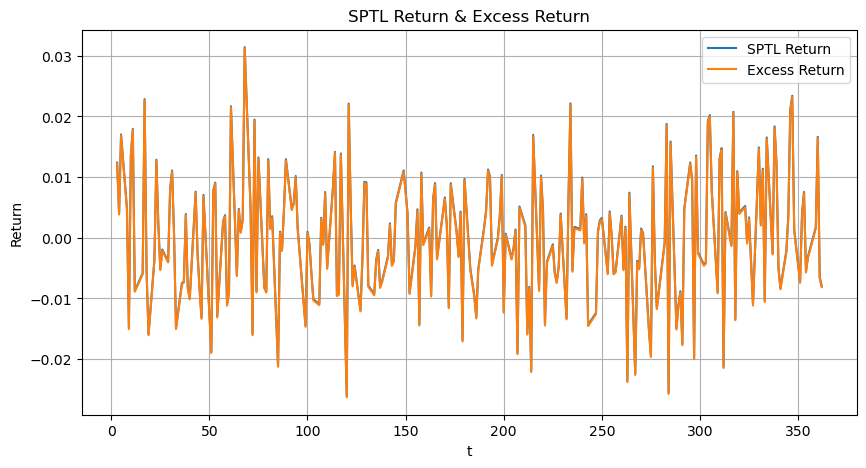

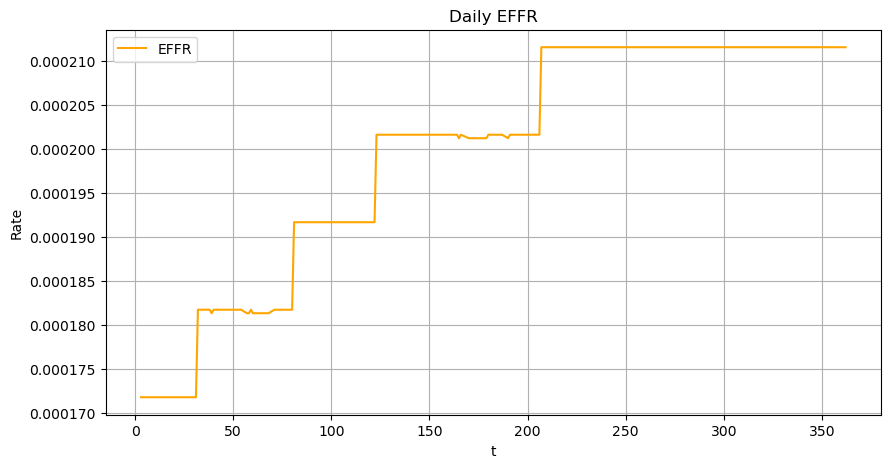

In [5]:
# Plot SPTL Return & Excess Return
plt.figure(figsize=(10, 5))
plt.plot(df['t'], df['Return'], label='SPTL Return')
plt.plot(df['t'], df['Excess Return'], label='Excess Return')
plt.xlabel('t')
plt.ylabel('Return')
plt.title('SPTL Return & Excess Return')
plt.legend()
plt.grid(True)
plt.show()

# Plot Risk-free Rate (EFFR)
plt.figure(figsize=(10, 5))
plt.plot(df['t'], df['Risk-free Rate'], color='orange', label='EFFR')
plt.xlabel('t')
plt.ylabel('Rate')
plt.title('Daily EFFR')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Split the dataset

split_index = int(0.7 * len(df))
train = df.iloc[:split_index]
test = df.iloc[split_index:]

print("Training Set:")
print(train)
print("\nTest Set:")
print(test)

Training Set:
          Date      Close    Return  Risk-free Rate  Excess Return    t
1   2023-01-04  27.669298  0.012374        0.000172       0.012203    3
2   2023-01-05  27.780346  0.003997        0.000172       0.003826    4
3   2023-01-06  28.261553  0.017027        0.000172       0.016855    5
4   2023-01-09  28.400364  0.004888        0.000172       0.004716    8
5   2023-01-10  27.983932 -0.014881        0.000172      -0.015053    9
..         ...        ...       ...             ...            ...  ...
169 2023-09-06  25.975519  0.001091        0.000212       0.000879  248
170 2023-09-07  26.051090  0.002901        0.000212       0.002689  249
171 2023-09-08  26.136101  0.003253        0.000212       0.003041  250
172 2023-09-11  25.984968 -0.005816        0.000212      -0.006028  253
173 2023-09-12  26.098312  0.004343        0.000212       0.004131  254

[173 rows x 6 columns]

Test Set:
          Date      Close    Return  Risk-free Rate  Excess Return    t
174 2023-09-13 

## Mean-reversion strategy

In [7]:
def mean_reversion_strategy(data, window, V_0=100000, L=10):
    ma_strategy = data.copy()

    # Moving Average and Signal
    ma_strategy['ma'] = ma_strategy['Close'].rolling(window=window).mean()
    ma_strategy['signal'] = 0
    ma_strategy.loc[ma_strategy['Close'] < ma_strategy['ma'], 'signal'] = 1
    ma_strategy.loc[ma_strategy['Close'] > ma_strategy['ma'], 'signal'] = -1
    ma_strategy['signal'] = ma_strategy['signal'].shift(1) # Shift signal 
    ma_strategy.iloc[0, ma_strategy.columns.get_loc('signal')] = 0

    # Prepare columns
    ma_strategy['theta'] = np.nan
    ma_strategy['M'] = np.nan
    ma_strategy['delta_V'] = np.nan
    ma_strategy['delta_V_cap'] = np.nan
    ma_strategy['delta_V_tot'] = np.nan
    ma_strategy['V_tot'] = np.nan

    ma_strategy.iloc[0, ma_strategy.columns.get_loc('V_tot')] = V_0 * L

    # Iterate over each row
    for t in range(1, len(ma_strategy)):
        V_tot = ma_strategy.iloc[t - 1]['V_tot']
        signal = ma_strategy.iloc[t]['signal']
        excess_ret = ma_strategy.iloc[t]['Excess Return']
        risk_free = ma_strategy.iloc[t]['Risk-free Rate']

        theta = V_tot * signal
        M = abs(theta) / L
        delta_V = excess_ret * theta
        delta_V_cap = (V_tot - M) * risk_free
        delta_V_tot = delta_V + delta_V_cap
        new_V_tot = V_tot + delta_V_tot

        ma_strategy.iloc[t, ma_strategy.columns.get_loc('theta')] = theta
        ma_strategy.iloc[t, ma_strategy.columns.get_loc('M')] = M
        ma_strategy.iloc[t, ma_strategy.columns.get_loc('delta_V')] = delta_V
        ma_strategy.iloc[t, ma_strategy.columns.get_loc('delta_V_cap')] = delta_V_cap
        ma_strategy.iloc[t, ma_strategy.columns.get_loc('delta_V_tot')] = delta_V_tot
        ma_strategy.iloc[t, ma_strategy.columns.get_loc('V_tot')] = new_V_tot

    return ma_strategy

In [8]:
# Search for the best window using training dataset
def find_best_window(train, window_range, V_0=100000, L=10):
    best_window = None
    best_V_tot = -np.inf
    window_results = {}
    
    for window in window_range:
        result = mean_reversion_strategy(train, window, V_0, L)
        final_V_tot = result['V_tot'].iloc[-1]
        window_results[window] = final_V_tot
        
        if final_V_tot > best_V_tot:
            best_V_tot = final_V_tot
            best_window = window
            
    return best_window, best_V_tot, window_results

window_range = range(1, 51)

best_window, best_V_tot, results = find_best_window(train, window_range)
print(f"Best window: {best_window} with final V_tot: {best_V_tot}")

Best window: 3 with final V_tot: 1328536.4176051803


In [10]:
train_ma_result = mean_reversion_strategy(train, window=3)
test_ma_result = mean_reversion_strategy(test, window=3)

# Calculate cumulative values for the train dataset
train_ma_result['cum_delta_V'] = train_ma_result['delta_V'].cumsum()
train_ma_result['cum_delta_V_cap'] = train_ma_result['delta_V_cap'].cumsum()
train_ma_result['cum_delta_V_tot'] = train_ma_result['delta_V_tot'].cumsum()

# Calculate cumulative values for the test dataset
test_ma_result['cum_delta_V'] = test_ma_result['delta_V'].cumsum()
test_ma_result['cum_delta_V_cap'] = test_ma_result['delta_V_cap'].cumsum()
test_ma_result['cum_delta_V_tot'] = test_ma_result['delta_V_tot'].cumsum()

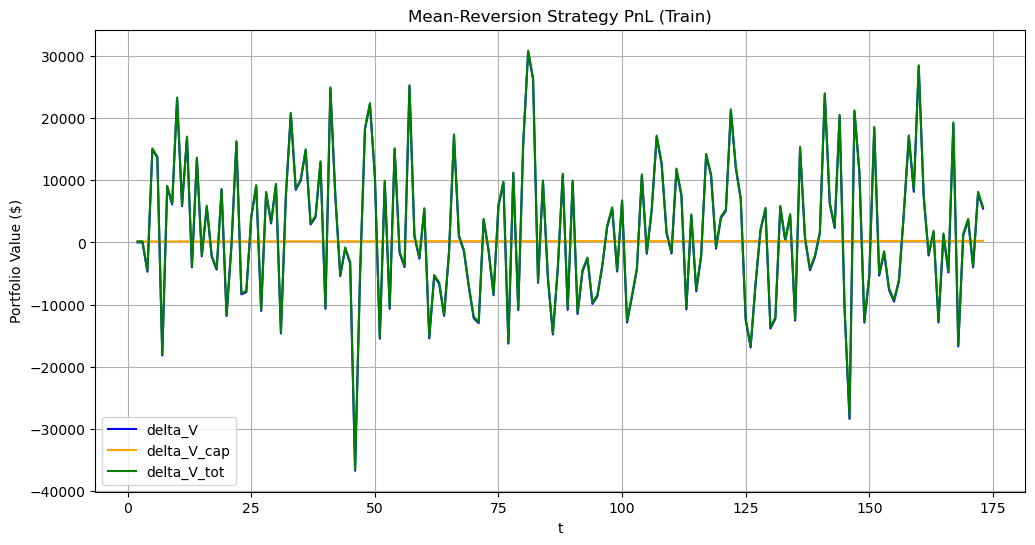

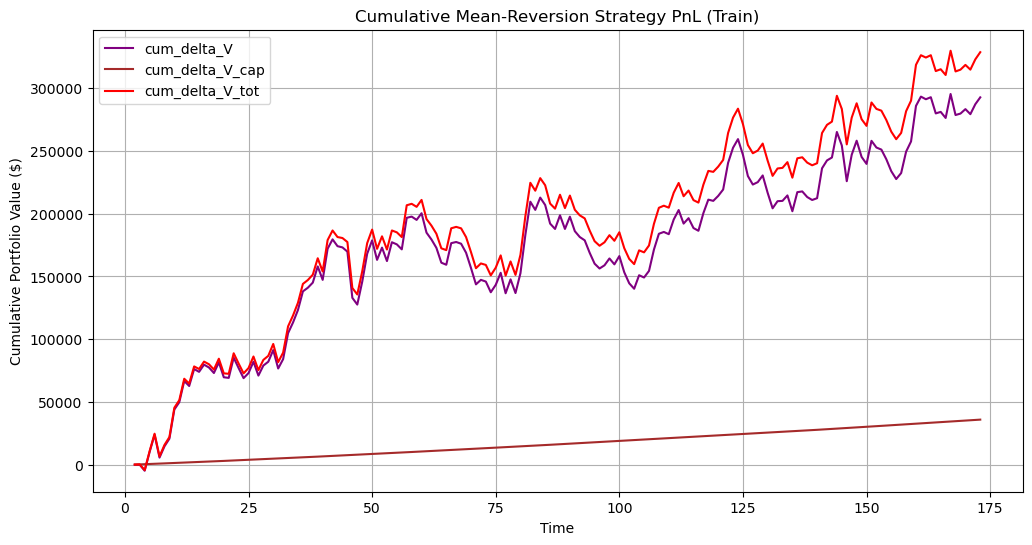

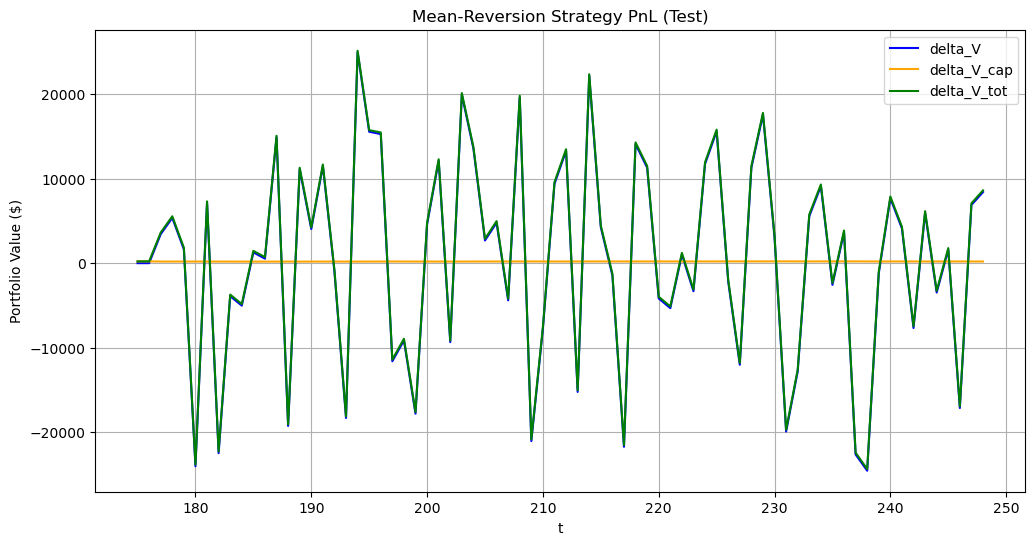

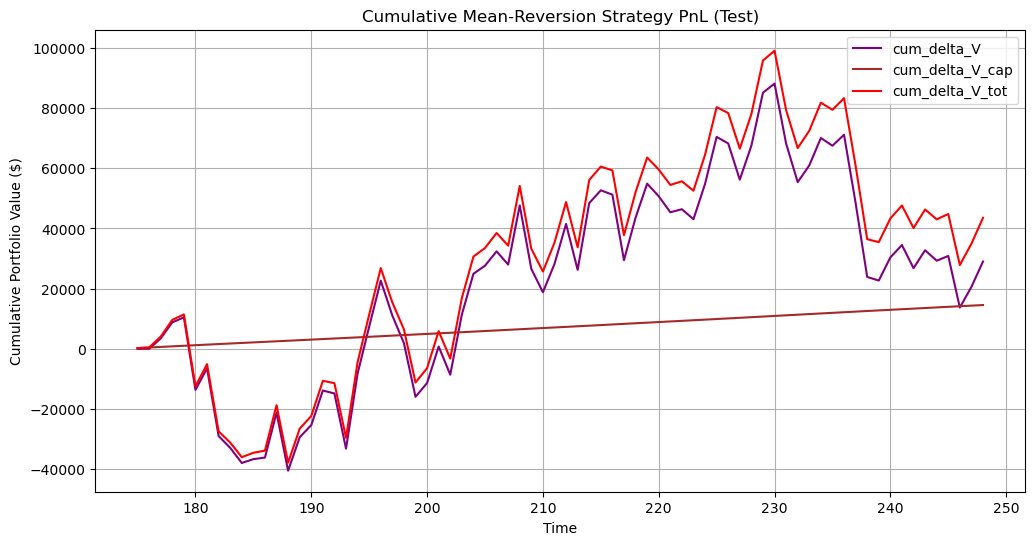

In [11]:
# Train dataset
plt.figure(figsize=(12, 6))
plt.plot(train_ma_result['delta_V'], label='delta_V', color='blue')  
plt.plot(train_ma_result['delta_V_cap'], label='delta_V_cap', color='orange') 
plt.plot(train_ma_result['delta_V_tot'], label='delta_V_tot', color='green')  
plt.title("Mean-Reversion Strategy PnL (Train)")
plt.xlabel("t")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_ma_result['cum_delta_V'], label='cum_delta_V', color='purple') 
plt.plot(train_ma_result['cum_delta_V_cap'], label='cum_delta_V_cap', color='brown') 
plt.plot(train_ma_result['cum_delta_V_tot'], label='cum_delta_V_tot', color='red') 
plt.title("Cumulative Mean-Reversion Strategy PnL (Train)")
plt.xlabel("Time")
plt.ylabel("Cumulative Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

# Test dataset
plt.figure(figsize=(12, 6))
plt.plot(test_ma_result['delta_V'], label='delta_V', color='blue') 
plt.plot(test_ma_result['delta_V_cap'], label='delta_V_cap', color='orange') 
plt.plot(test_ma_result['delta_V_tot'], label='delta_V_tot', color='green')
plt.title("Mean-Reversion Strategy PnL (Test)")
plt.xlabel("t")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_ma_result['cum_delta_V'], label='cum_delta_V', color='purple') 
plt.plot(test_ma_result['cum_delta_V_cap'], label='cum_delta_V_cap', color='brown') 
plt.plot(test_ma_result['cum_delta_V_tot'], label='cum_delta_V_tot', color='red')
plt.title("Cumulative Mean-Reversion Strategy PnL (Test)")
plt.xlabel("Time")
plt.ylabel("Cumulative Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Sharpe ratio
train_ma_result['r'] = (train_ma_result['V_tot'] - train_ma_result['V_tot'].shift(1)) / train_ma_result['V_tot'] 
train_mean_r= train_ma_result['r'].mean()
train_sd_r = train_ma_result['r'].std()

test_ma_result['r'] = (test_ma_result['V_tot'] - test_ma_result['V_tot'].shift(1)) / test_ma_result['V_tot'] 
test_mean_r= test_ma_result['r'].mean()
test_sd_r = test_ma_result['r'].std()

train_sharpe_ratio = train_mean_r / train_sd_r
test_sharpe_ratio = test_mean_r / test_sd_r

print("Sharpe Ratio (Train):", train_sharpe_ratio)
print("Sharpe Ratio (Test):", test_sharpe_ratio)


# Max drawdown
def maximum_drawdown(df, value_col='V_tot'):
    df['Peak'] = df[value_col].cummax()
    df['Drawdown'] = (df['Peak'] - df[value_col]) / df['Peak']
    max_drawdown = df['Drawdown'].max()
    return max_drawdown

mdd_train = maximum_drawdown(train_ma_result)
mdd_test = maximum_drawdown(test_ma_result)
 
print(f"Maximum Drawdown (Train): {mdd_train}")
print(f"Maximum Drawdown (Test): {mdd_test}")


# Calmar ratio
def calmar_ratio(mean_daily_return, max_drawdown):
    annualized_return = (1 + mean_daily_return) ** 252 - 1
    return annualized_return / max_drawdown

train_calmar_ratio = calmar_ratio(train_mean_r, mdd_train)
test_calmar_ratio = calmar_ratio(test_mean_r, mdd_test)

print("Calmar Ratio (Train)", train_calmar_ratio)
print("Calmar Ratio (Test)", test_calmar_ratio)

Sharpe Ratio (Train): 0.16687158364378565
Sharpe Ratio (Test): 0.04193430185760394
Maximum Drawdown (Train): 0.05573754757155574
Maximum Drawdown (Test): 0.06482813860612953
Calmar Ratio (Train) 8.929673089164838
Calmar Ratio (Test) 2.0908199648593255


## ARIMAX (Yield spread)

In [13]:
spread = spread.rename(columns={'observation_date': 'Date', 'T10Y2Y':'Spread'})

spread['Date'] = pd.to_datetime(spread['Date'])
df['Date'] = pd.to_datetime(df['Date'])
arimax_df = pd.merge(df[['Date','Close','Return', 'Risk-free Rate', 'Excess Return']], spread, on='Date', how='inner')
arimax_df = arimax_df[arimax_df['Date'] != '2023-10-09']
arimax_df['Diff_Spread'] = arimax_df['Spread'].diff()
arimax_df = arimax_df.iloc[1:]

print(arimax_df)

          Date      Close    Return  Risk-free Rate  Excess Return  Spread  \
1   2023-01-05  27.780346  0.003997        0.000172       0.003826   -0.74   
2   2023-01-06  28.261553  0.017027        0.000172       0.016855   -0.69   
3   2023-01-09  28.400364  0.004888        0.000172       0.004716   -0.66   
4   2023-01-10  27.983932 -0.014881        0.000172      -0.015053   -0.63   
5   2023-01-11  28.372597  0.013699        0.000172       0.013527   -0.66   
..         ...        ...       ...             ...            ...     ...   
243 2023-12-22  27.635378 -0.003114        0.000212      -0.003326   -0.41   
244 2023-12-26  27.683191  0.001727        0.000212       0.001516   -0.37   
245 2023-12-27  28.151747  0.016644        0.000212       0.016432   -0.41   
246 2023-12-28  27.970064 -0.006496        0.000212      -0.006707   -0.42   
247 2023-12-29  27.750126 -0.007926        0.000212      -0.008137   -0.35   

     Diff_Spread  
1          -0.07  
2           0.05  
3     

In [14]:
# ADF test

def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f'ADF Statistic for {name}: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Stationary' if result[1] <= 0.05 else 'Non-Stationary')
    
adf_test(sptl['Close'], 'SPTL Prices')
adf_test(sptl['Return'], 'SPTL Returns')
adf_test(arimax_df['Spread'], 'Yield Spread')
adf_test(arimax_df['Diff_Spread'], 'Differenced Spread')

ADF Statistic for SPTL Prices: -1.2451388342297243
p-value: 0.6538831627077586
Non-Stationary
ADF Statistic for SPTL Returns: -18.112499010784205
p-value: 2.5350707759236676e-30
Stationary
ADF Statistic for Yield Spread: -1.9837969258017767
p-value: 0.2937224588492682
Non-Stationary
ADF Statistic for Differenced Spread: -10.286321248347459
p-value: 3.66693769801788e-18
Stationary


In [15]:
train_size = int(len(arimax_df) * 0.7)
train_arimax = arimax_df.iloc[:train_size]
test_arimax = arimax_df.iloc[train_size:]

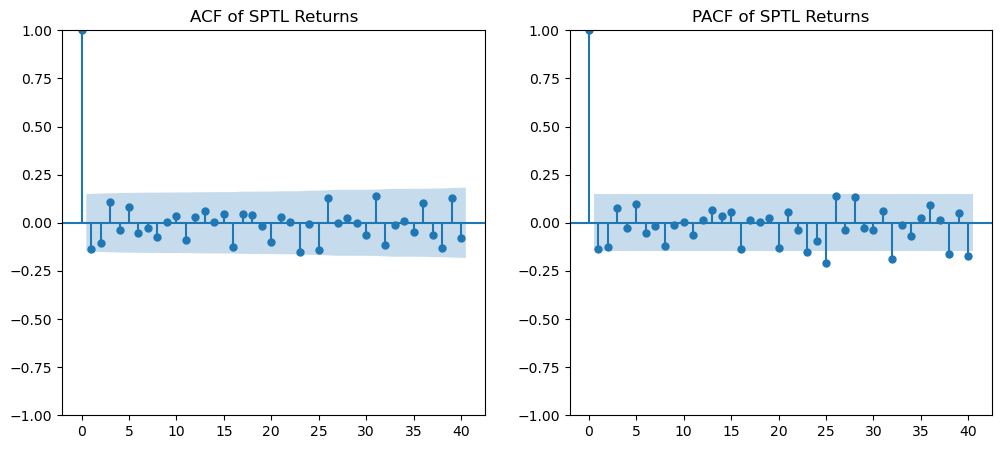

In [17]:
# Selecting (p, 0, q)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(train['Return'].dropna(), lags=40, ax=axes[0])
plot_pacf(train['Return'].dropna(), lags=40, ax=axes[1])
axes[0].set_title('ACF of SPTL Returns')
axes[1].set_title('PACF of SPTL Returns')
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.16388D+00    |proj g|=  7.75286D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2      7      1     0     0   7.046D-02  -3.164D+00
  F =  -3.1638958002322850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                 Return   No. Observations:                  247
Model:               SARIMAX(1, 0, 1

/Users/annabartyzel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/annabartyzel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


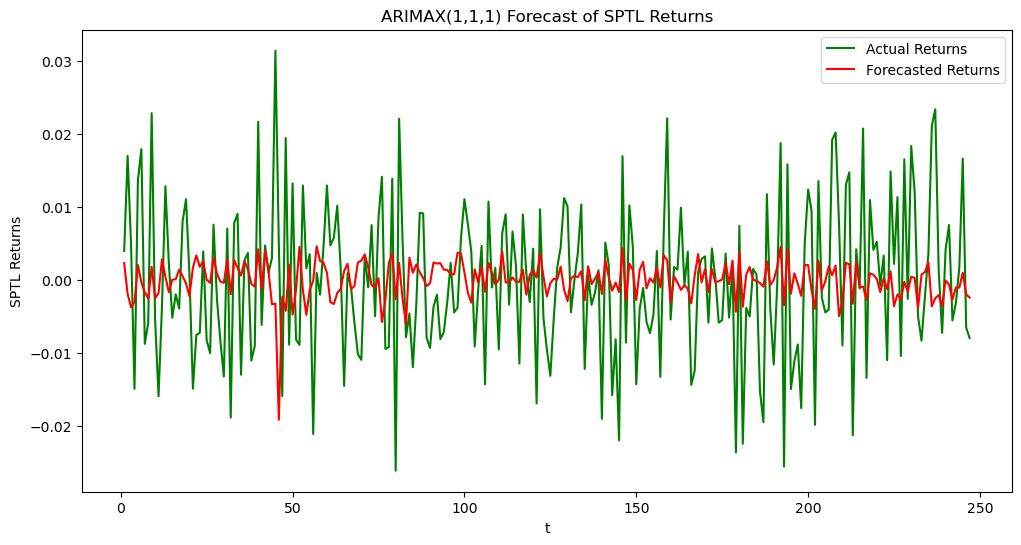

In [18]:
# ARIMAX Model

model = SARIMAX(arimax_df['Return'], exog=arimax_df[['Diff_Spread']], order=(1, 0, 1))
result = model.fit()
print(result.summary())

# Forecast
forecast = result.predict(start=0, end=len(arimax_df) - 1, exog=arimax_df[['Diff_Spread']])

# Plotting actual vs forecasted returns
plt.figure(figsize=(12, 6))
time_steps = range(1, len(arimax_df) + 1) 
plt.plot(time_steps, arimax_df['Return'], label='Actual Returns', color='green')
plt.plot(time_steps, forecast, label='Forecasted Returns', color='red')
plt.title('ARIMAX(1,1,1) Forecast of SPTL Returns')
plt.xlabel('t')
plt.ylabel('SPTL Returns')
plt.legend()
plt.show()

In [19]:
train_size = int(len(arimax_df) * 0.7)
train_arimax = arimax_df.iloc[:train_size].copy()
test_arimax = arimax_df.iloc[train_size:].copy()

In [23]:
forecast_train = result.predict(start=0, end=len(train_arimax)-1, exog=train_arimax[['Diff_Spread']])
forecast_test = result.predict(start=len(train_arimax), end=len(train_arimax) + len(test_arimax) - 1, exog=test_arimax[['Diff_Spread']])

In [24]:
# Train dataset
initial_price_train = train_arimax['Close'].iloc[0]
forecasted_prices_train = [initial_price_train]

for ret in forecast_train:
    next_price = forecasted_prices_train[-1] * (1 + ret)
    forecasted_prices_train.append(next_price)

forecasted_prices_train = forecasted_prices_train[1:]
train_arimax['Forecasted_Price'] = forecasted_prices_train

# Test dataset
initial_price_test = test_arimax['Close'].iloc[0]
forecasted_prices_test = [initial_price_test]

for ret in forecast_test:
    next_price = forecasted_prices_test[-1] * (1 + ret)
    forecasted_prices_test.append(next_price)

forecasted_prices_test = forecasted_prices_test[1:]
test_arimax['Forecasted_Price'] = forecasted_prices_test

print(train_arimax)

          Date      Close    Return  Risk-free Rate  Excess Return  Spread  \
1   2023-01-05  27.780346  0.003997        0.000172       0.003826   -0.74   
2   2023-01-06  28.261553  0.017027        0.000172       0.016855   -0.69   
3   2023-01-09  28.400364  0.004888        0.000172       0.004716   -0.66   
4   2023-01-10  27.983932 -0.014881        0.000172      -0.015053   -0.63   
5   2023-01-11  28.372597  0.013699        0.000172       0.013527   -0.66   
..         ...        ...       ...             ...            ...     ...   
168 2023-09-06  25.975519  0.001091        0.000212       0.000879   -0.71   
169 2023-09-07  26.051090  0.002901        0.000212       0.002689   -0.67   
170 2023-09-08  26.136101  0.003253        0.000212       0.003041   -0.72   
171 2023-09-11  25.984968 -0.005816        0.000212      -0.006028   -0.68   
172 2023-09-12  26.098312  0.004343        0.000212       0.004131   -0.71   

     Diff_Spread  Forecasted_Price  
1          -0.07         2

In [25]:
def trend_strategy(data, V_0=100000, L=10):
    arimax_strategy = data.copy()

    # Signal
    arimax_strategy['signal'] = 0
    arimax_strategy.loc[arimax_strategy['Forecasted_Price'].shift(1) > arimax_strategy['Close'], 'signal'] = 1  
    arimax_strategy.loc[arimax_strategy['Forecasted_Price'].shift(1) < arimax_strategy['Close'], 'signal'] = -1  

    # Prepare columns
    arimax_strategy['theta'] = np.nan 
    arimax_strategy['M'] = np.nan 
    arimax_strategy['delta_V'] = np.nan     
    arimax_strategy['delta_V_cap'] = np.nan  
    arimax_strategy['delta_V_tot'] = np.nan  
    arimax_strategy['V_tot'] = np.nan 
    
    arimax_strategy.iloc[0, arimax_strategy.columns.get_loc('V_tot')] = V_0 * L
    prev_theta = 0

    for t in range(0, len(arimax_strategy)-1):
        V_tot = arimax_strategy.iloc[t]['V_tot']
        signal = arimax_strategy.iloc[t]['signal']
        excess_ret = arimax_strategy.iloc[t]['Excess Return']
        risk_free = arimax_strategy.iloc[t]['Risk-free Rate']
        
        theta = V_tot * signal
        M = abs(theta) / L
        delta_V = excess_ret * prev_theta
        delta_V_cap = (V_tot - M) * risk_free
        delta_V_tot = delta_V + delta_V_cap
    
        prev_theta = theta
        new_V_tot = V_tot + delta_V_tot
        
        arimax_strategy.iloc[t, arimax_strategy.columns.get_loc('theta')] = theta
        arimax_strategy.iloc[t, arimax_strategy.columns.get_loc('M')] = M
        arimax_strategy.iloc[t, arimax_strategy.columns.get_loc('delta_V')] = delta_V
        arimax_strategy.iloc[t, arimax_strategy.columns.get_loc('delta_V_cap')] = delta_V_cap
        arimax_strategy.iloc[t, arimax_strategy.columns.get_loc('delta_V_tot')] = delta_V_tot
        arimax_strategy.iloc[t+1, arimax_strategy.columns.get_loc('V_tot')] = new_V_tot

    return arimax_strategy

train_arimax_result = trend_strategy(train_arimax)
test_arimax_result = trend_strategy(test_arimax)

In [26]:
# Cumulative values

train_arimax_result['cum_delta_V'] = train_arimax_result['delta_V'].cumsum()
train_arimax_result['cum_delta_V_cap'] = train_arimax_result['delta_V_cap'].cumsum()
train_arimax_result['cum_delta_V_tot'] = train_arimax_result['delta_V_tot'].cumsum()

test_arimax_result['cum_delta_V'] = test_arimax_result['delta_V'].cumsum()
test_arimax_result['cum_delta_V_cap'] = test_arimax_result['delta_V_cap'].cumsum()
test_arimax_result['cum_delta_V_tot'] = test_arimax_result['delta_V_tot'].cumsum()

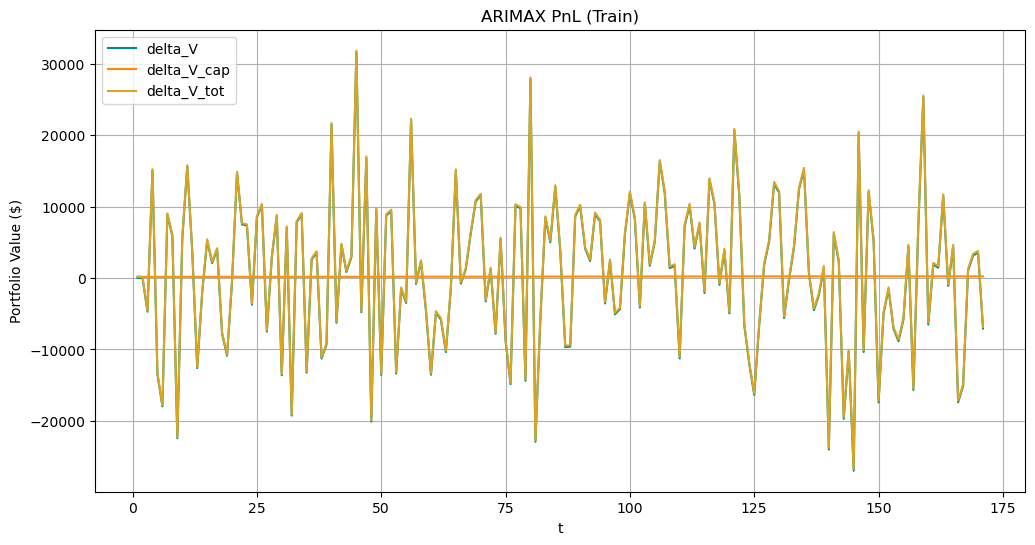

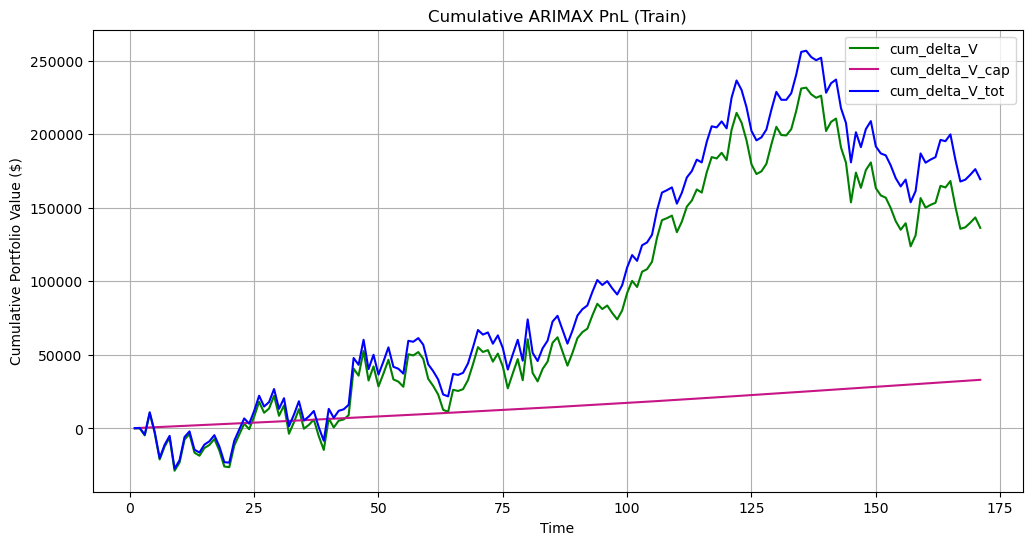

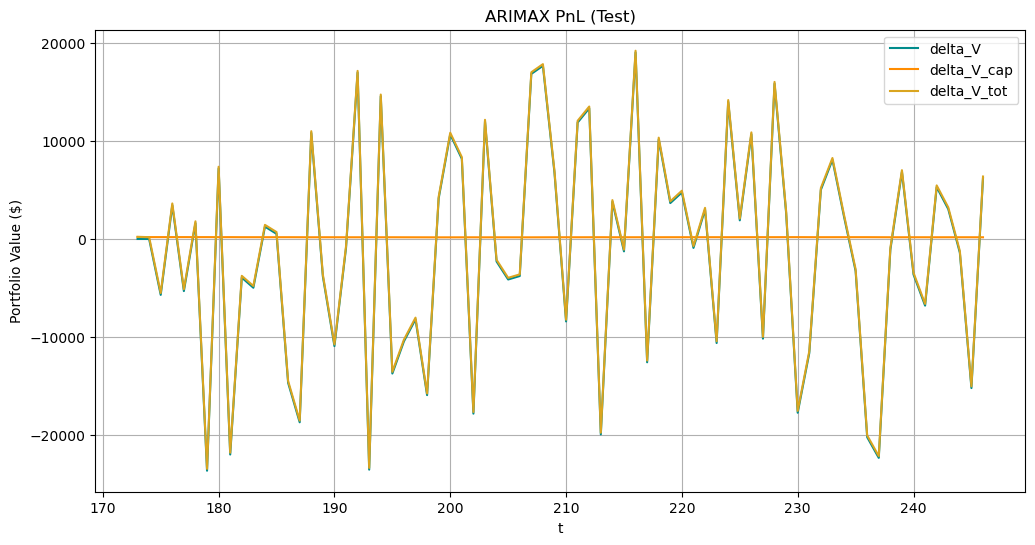

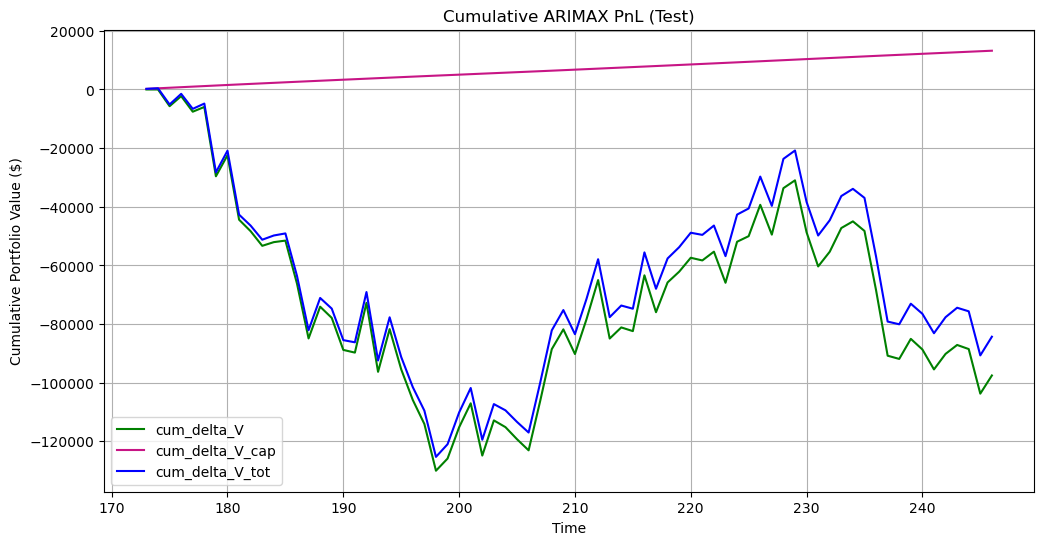

In [27]:
pnl_colors = {
    'delta_V': 'darkcyan',
    'delta_V_cap': 'darkorange',
    'delta_V_tot': 'goldenrod'
}

cum_pnl_colors = {
    'cum_delta_V': 'green',
    'cum_delta_V_cap': 'mediumvioletred',
    'cum_delta_V_tot': 'blue'
}

# Train dataset 

plt.figure(figsize=(12, 6))
plt.plot(train_arimax_result['delta_V'], label='delta_V', color=pnl_colors['delta_V'])
plt.plot(train_arimax_result['delta_V_cap'], label='delta_V_cap', color=pnl_colors['delta_V_cap'])
plt.plot(train_arimax_result['delta_V_tot'], label='delta_V_tot', color=pnl_colors['delta_V_tot'])
plt.title("ARIMAX PnL (Train)")
plt.xlabel("t")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_arimax_result['cum_delta_V'], label='cum_delta_V', color=cum_pnl_colors['cum_delta_V'])
plt.plot(train_arimax_result['cum_delta_V_cap'], label='cum_delta_V_cap', color=cum_pnl_colors['cum_delta_V_cap'])
plt.plot(train_arimax_result['cum_delta_V_tot'], label='cum_delta_V_tot', color=cum_pnl_colors['cum_delta_V_tot'])
plt.title("Cumulative ARIMAX PnL (Train)")
plt.xlabel("Time")
plt.ylabel("Cumulative Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

# Test dataset

plt.figure(figsize=(12, 6))
plt.plot(test_arimax_result['delta_V'], label='delta_V', color=pnl_colors['delta_V'])
plt.plot(test_arimax_result['delta_V_cap'], label='delta_V_cap', color=pnl_colors['delta_V_cap'])
plt.plot(test_arimax_result['delta_V_tot'], label='delta_V_tot', color=pnl_colors['delta_V_tot'])
plt.title("ARIMAX PnL (Test)")
plt.xlabel("t")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_arimax_result['cum_delta_V'], label='cum_delta_V', color=cum_pnl_colors['cum_delta_V'])
plt.plot(test_arimax_result['cum_delta_V_cap'], label='cum_delta_V_cap', color=cum_pnl_colors['cum_delta_V_cap'])
plt.plot(test_arimax_result['cum_delta_V_tot'], label='cum_delta_V_tot', color=cum_pnl_colors['cum_delta_V_tot'])
plt.title("Cumulative ARIMAX PnL (Test)")
plt.xlabel("Time")
plt.ylabel("Cumulative Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Sharpe ratio
train_arimax_result['%PnL'] = (train_arimax_result['V_tot'] - train_arimax_result['V_tot'].shift(1)) / train_arimax_result['V_tot'] 
train_mean_PnL= train_arimax_result['%PnL'].mean()
train_sd_PnL = train_arimax_result['%PnL'].std()

test_arimax_result['%PnL'] = (test_arimax_result['V_tot'] - test_arimax_result['V_tot'].shift(1)) / test_arimax_result['V_tot'] 
test_mean_PnL= test_arimax_result['%PnL'].mean()
test_sd_PnL = test_arimax_result['%PnL'].std()

train_sharpe_ratio = train_mean_PnL / train_sd_PnL
test_sharpe_ratio = test_mean_PnL / test_sd_PnL

print("Sharpe Ratio (Train):", train_sharpe_ratio)
print("Sharpe Ratio (Test):", test_sharpe_ratio)


# Max drawdown
def maximum_drawdown(df, value_col='V_tot'):
    df['Peak'] = df[value_col].cummax()
    df['Drawdown'] = (df['Peak'] - df[value_col]) / df['Peak']
    max_drawdown = df['Drawdown'].max()
    return max_drawdown

mdd_train = maximum_drawdown(train_arimax_result)
mdd_test = maximum_drawdown(test_arimax_result)
 
print(f"Maximum Drawdown (Train): {mdd_train}")
print(f"Maximum Drawdown (Test): {mdd_test}")


# Calmar ratio
def calmar_ratio(mean_daily_return, max_drawdown):
    annualized_return = (1 + mean_daily_return) ** 252 - 1
    return annualized_return / max_drawdown

train_calmar_ratio = calmar_ratio(train_mean_PnL, mdd_train)
test_calmar_ratio = calmar_ratio(test_mean_PnL, mdd_test)

print("Calmar Ratio (Train)", train_calmar_ratio)
print("Calmar Ratio (Test)", test_calmar_ratio)

Sharpe Ratio (Train): 0.08905891427905385
Sharpe Ratio (Test): -0.10532934136533749
Maximum Drawdown (Train): 0.0819828000097257
Maximum Drawdown (Test): 0.12565564801620763
Calmar Ratio (Train) 2.9785902242402886
Calmar Ratio (Test) -2.168620833539868
